# $\textbf{Project 3}$
## Manbir Kaberwal
## EAE 127


## Introduction

In this problem set, we will implement a source panel method solver to discretize geometry into panels, using functions such as the Panel class, integral_normal(), and integral_tangent(). The goal is to compute the flow over a non-rotating cylinder, analyze symmetric and cambered airfoil panel methods, and solve additional problems related to irrotationality, boundary layers, potential flow, and pressure estimation on a cylindrical strut. Notably, we will be examining the sensitivity of the solution to the number of panels used and comparing the accuracy of the source panel method with XFOIL for different airfoil types. The results and analysis should shed light on the behavior of potential flow around various geometries, highlighting the strengths and limitations of the source panel method.

Imports

In [5]:
import math
import pyxfoil
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Problem 1 Source Panel Method
# Panel Classification

## Code
This code defines a Python class called Panel that represents a panel object, which will be used in the source panel method. Here's a brief explanation of what each part of the code does:

- Class Initialization (init): Initializes the Panel class with endpoints (xa, ya) and (xb, yb) to define the panel's geometry.

- Center and Length Calculation: Calculates the center (xc, yc) of the panel and the length of the panel using the endpoints.

- Panel Orientation: Determines the orientation of the panel, represented by the angle beta between the x-axis and the unit vector normal to the panel. It also specifies if the panel is on the upper or lower surface of the geometry based on the angle beta.

- Additional Parameters: Initializes additional parameters, such as sigma (strength of the source/sink), vt (tangential velocity), and cp (pressure coefficient) to zero. These parameters will be used in the source panel method calculations.

Overall, this class provides a structured way to handle and manipulate the properties of each panel, such as its geometry, orientation, and parameters. It serves as a fundamental building block for implementing the source panel method and analyzing aerodynamic properties of various geometries, such as airfoils and cylinders.

Here is Panel Classification

In [6]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya           # Defines the first end point
        self.xb, self.yb = xb, yb           # Defines the second end point

        # Defining center point and panel parameters
        # You will need to define these yourself:
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2         # Control point or center point (How do you find the center of two points?)
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)    # Length of the panel (How do you find the distance between two points)

        # For the orientation of the panel (angle between x axis and the unit vector normal to the panel)
        if xb - xa <= 0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)

        # Location of the panel (we will use this later when we expand our analys to airfoils)
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'

    
        # Create these and set the equal to zero for now

        self.sigma = 0.0 
        self.vt = 0.0
        self.cp = 0.0
        



# Intergration of Normal Velocity

## Equations

Normal: $$ u_{n_{i}} = U_{\infty}cos(\beta_{i}) + \frac{\sigma_{i}}{2} + \sum_{j=1 , j \neq i }^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j}))cos\beta_{i}  + (y_{c_{i}} - y_{j}(s_{j}))sin\beta_{i} } {(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

## Code

This code defines a function called integral_normal that evaluates the contribution of a panel at the center-point of another panel in the normal direction. Here's a brief explanation of what each part of the code does:

- Function Definition: The integral_normal function takes two arguments, p_i and p_j, which represent two Panel objects. It calculates the contribution of the panel p_j at the center-point of panel p_i in the normal direction.

- Integrand Definition: Within the integral_normal function, an integrand is defined as a function of the variable s. This integrand is a mathematical expression that accounts for the normal contribution of the panel p_j at the center-point of panel p_i. It involves complex geometric computations using the properties of the two panels.

- Integration: The integrate.quad function is used to numerically compute the definite integral of the defined integrand over the interval [0.0, p_j.length]. This step computes the total contribution of panel p_j at the center-point of panel p_i in the normal direction.

Overall, this function plays a crucial role in the source panel method calculations, enabling the assessment of the normal velocity contribution from one panel to another. The numerical integration provides a quantitative measure of the influence of each panel on the aerodynamic behavior around a given geometry.

In [7]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.

    Parameters:
    -----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated. 
    """

    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

# Intergration of Tangential Velocity

## Equation

Tangential velocity equation:

### $$ u_{t_{i}} = -U_{\infty}sin(\beta_{i}) +  \sum_{j=1 , j \neq i}^{N_{p}} \frac{\sigma_{j}}{2\pi} \int  \frac{(x_{c_{i}} - x_{j}(s_{j})) \frac{\partial_{x_{c_{i}}}}{\partial_{t_{i}}}  + (y_{c_{i}} - y_{j}(s_{j})) \frac{\partial_{y_{c_{i}}}}{\partial_{t_{i}}}    }{(x_{c_{i}} - x_{j}(s))^2 + (y_{c_{i}} - y_{j}(s)) ^2} \,ds_{j}  $$

## Code
This code defines a function called integral_tangential that calculates the tangential contribution of a panel at the center-point of another panel. Here's a brief explanation of what each part of the code does:

- Function Definition: The integral_tangential function takes two arguments, p_i and p_j, representing two Panel objects. It is responsible for computing the tangential contribution of the panel p_j at the center-point of panel p_i.

- Integrand Definition: Within the integral_tangential function, an integrand is defined as a function of the variable s. This integrand represents the mathematical expression that quantifies the tangential contribution of the panel p_j at the center-point of panel p_i. It involves intricate geometric calculations utilizing the properties of the two panels.

- Integration: The integrate.quad function is used for numerical integration to compute the definite integral of the defined integrand over the interval [0.0, p_j.length]. This step facilitates the comprehensive assessment of the tangential velocity contribution from one panel to another.

In summary, this function is essential in the context of the source panel method, enabling the evaluation of the tangential velocity contribution from one panel to another. The integration process yields a quantitative measure of the impact of panel-to-panel interactions on the overall aerodynamic characteristics of a given geometry.

In [8]:
def integral_tangential(p_i, p_j):

    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

# Analysis of Panel Method

## Code

The provided code defines a function called analyze_panels that performs the panel analysis. Here's a brief explanation of what each part of the code does:

- Function Definition: The analyze_panels function takes two arguments, panels and u_inf, where panels represents an array of Panel objects, and u_inf is the freestream velocity.

- Initialization: The function initializes variables and arrays needed for the panel analysis, setting up matrices for normal and tangential velocity calculations.

- Normal Velocity Calculation: The function computes the normal velocity contributions using the defined integral_normal function and constructs the source influence matrix A_n of the linear system. It then solves the linear system to find the values of the source strength (sigma) for each panel.

- Tangential Velocity Calculation: Similar to the normal velocity calculation, the function computes the tangential velocity contributions using the defined integral_tangential function. It constructs the source influence matrix A_t and computes the right-hand side b_t of the linear system. It solves the linear system to find the tangential velocity for each panel.

- Surface Pressure Coefficient Calculation: Using the tangential velocity values, the function calculates the surface pressure coefficient (cp) for each panel.

In summary, this function is crucial for the implementation of the source panel method, as it facilitates the calculation of key aerodynamic parameters, such as the source strength, tangential velocity, and surface pressure coefficient, based on the defined panels and the freestream velocity.

In [9]:
def analyze_panels(panels, u_inf):
    
    Num = len(panels)

    # First we need the Normal Velocity Calculations

    A_n = np.empty((Num, Num), dtype = float)
    np.fill_diagonal(A_n, 0.5)
        # Whenever we have i = j, we have sigma(i)/2 or sigma(i)*0.5. Thus, on our diagonal for matrix A we should have 0.5 
        # The diagonal of a matrix means i = j i.e (1,1), (2,2), etc etc.

    # Create the source influence matrix [A] of the linear system
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A_n[i,j] = (0.5/math.pi) * integral_normal(p_i, p_j)

    # Create the right hand side [b] of the linear system
    b_n = - u_inf * np.cos([p.beta for p in panels])

    sigma = np.linalg.solve(A_n,b_n)

    for i, panel in enumerate(panels):
        panel.sigma = sigma[i]

    # ====================================================================== #
    # Now we need the Tangential Velocity Calculations
    A_t = np.empty((Num, Num), dtype = float)
    np.fill_diagonal(A_t, 0.0)

    # Create the source influence matrix [A] of the linear system
    # STUDENTS WILL FILL THIS IN DELETE LATER
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i!=j:
                A_t[i,j] = (0.5 / math.pi) * integral_tangential(p_i, p_j)

    # Create the right hand side [b] of the linear system
    # STUDENTS ALSO FILL THIS IN
    b_t = -u_inf * np.sin([p.beta for p in panels])

    # Finally, we compute the tangential velocity:
    # STUDENTS ALSO FILL THIS IN
    vt = np.dot(A_t, sigma) + b_t

    for i, panel in enumerate(panels):
        panel.vt = vt[i]
    
    # STUDENTS FILL THIS IN
    # Finally, lets use our tangential velocity to calculate surface pressure Cp:
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/u_inf)**2

    print('Panel Analysis Complete!')



# Problem 2 Flow Over A Non-Rotating Cylinder


This code segment is essential for discretizing the circular cylinder into a desired number of panels, allowing for the subsequent analysis of the aerodynamic behavior around the cylinder using the source panel method. It utilizes an array to iterate over the lenght of N_panels array.

In [10]:
N_panels = np.array([10, 40, 160])
R = 0.75

x_circle = R * np.cos(np.linspace(0.0, 2 * math.pi, 100))
y_circle = R * np.sin(np.linspace(0.0, 2 * math.pi, 100))

# Update the for loop to iterate over the length of the array N_panels
cylinder_panels = np.empty(len(N_panels), dtype=object)
for j in range(len(N_panels)):
    x_points = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels[j] + 1))
    y_points = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels[j] + 1))

    # Create panel objects and store them in the array cylinder_panels
    for i in range(N_panels[j]):
        cylinder_panels[j] = Panel(x_points[i], y_points[i], x_points[i + 1], y_points[i + 1])


## Approach

 The approach focuses on creating clear and informative visual representations to aid in the understanding of the panel distribution for the circular geometry.


## Code

The code defines a function plot_figure that generates a visual representation of the circular geometry and the panels used for discretization. It plots the circle/cylinder along with the panel points, highlighting the end points and center points for each panel. The function is then called for various configurations of the number of panels, creating visualizations for each case. The plots provide a clear understanding of the panel distribution and the discretization process for the circular geometry under different panel configurations.

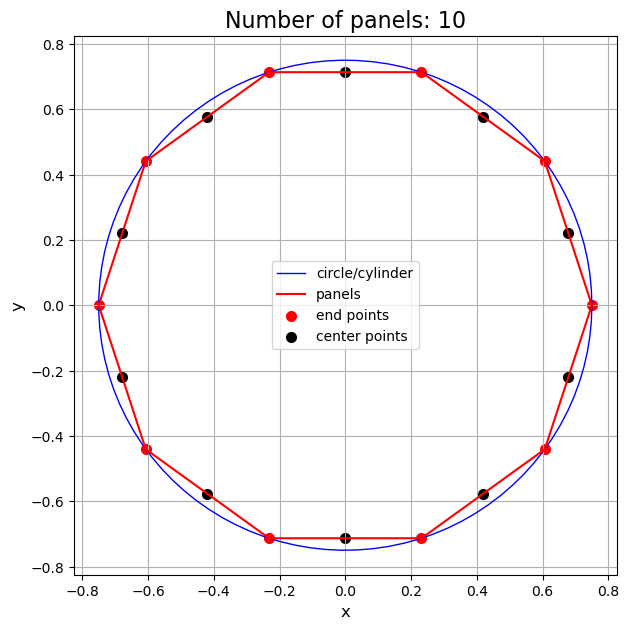

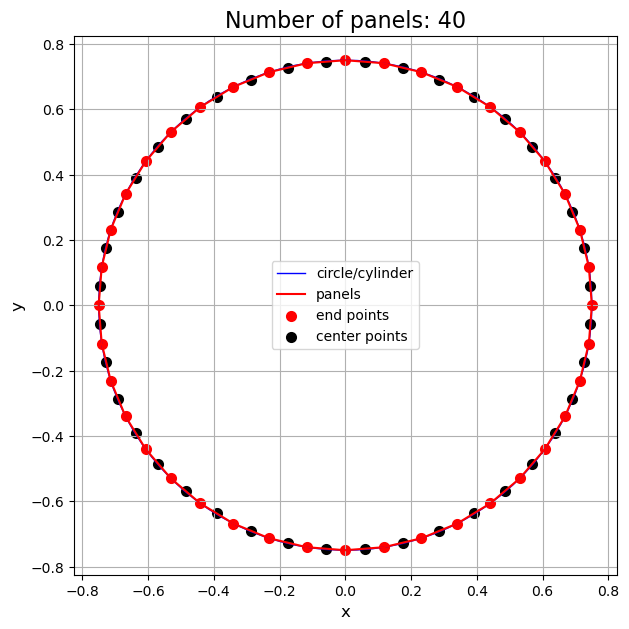

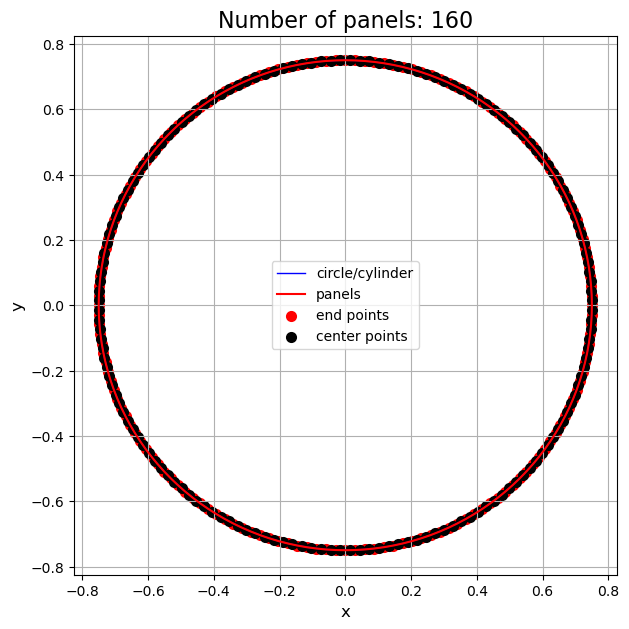

In [13]:
def plot_figure(N_panels, R, x_circle, y_circle, x_points, y_points, cylinder_panels):
    plt.figure(figsize=(7, 7))
    plt.grid()
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('Number of panels: %d' % N_panels, fontsize=16)
    plt.plot(x_circle, y_circle, label='circle/cylinder', color='b', linewidth=1)
    plt.plot(x_points, y_points, label='panels', color='r')

    plt.scatter([p.xa for p in cylinder_panels], [p.ya for p in cylinder_panels], label='end points', color='r', linewidth=2)
    plt.scatter([p.xc for p in cylinder_panels], [p.yc for p in cylinder_panels], label='center points', color='k', linewidth=2)

    plt.legend(loc='best')
    plt.show()

# Call the function for each value in the N_panels array
N_panels = np.array([10, 40, 160])
R = 0.75
x_circle = R * np.cos(np.linspace(0.0, 2 * math.pi, 100))
y_circle = R * np.sin(np.linspace(0.0, 2 * math.pi, 100))

for panels in N_panels:
    x_points = R * np.cos(np.linspace(0.0, 2 * math.pi, panels + 1))
    y_points = R * np.sin(np.linspace(0.0, 2 * math.pi, panels + 1))
    
    cylinder_panels = np.empty(panels, dtype=object)
    for i in range(panels):
        cylinder_panels[i] = Panel(x_points[i], y_points[i], x_points[i + 1], y_points[i + 1])

    plot_figure(panels, R, x_circle, y_circle, x_points, y_points, cylinder_panels)

# Error Calculation

## Approach 

The approach is to first sets up parameters and initializes the geometry for a non-rotating cylinder. It then creates panels for different configurations, performs panel analysis, and calculates the error between analytical and panel method solutions. The code generates comparative plots and provides insights into the accuracy of the source panel method for varying numbers of panels applied to the non-rotating cylinder.

## Equations

### $\int_{0}^{2\pi} C_{P,Analytic} \, d\theta_{Analytic} - \int_{0}^{2\pi} C_{P,Panel} \, d\theta_{Panel}$


## Code 
The code below performs analysis and plotting for the source panel method applied to the flow over a non-rotating cylinder, investigating the effect of the number of panels on the accuracy of the solution. The calculate_error function computes the error between the analytical and panel method solutions, utilizing the analytical surface pressure coefficient, the panel data, and the discretization parameter. The analyze_and_plot_panels function conducts the panel analysis, computes the surface pressure coefficient, and generates a comparative plot of the analytical and panel method results. The code then utilizes a loop to iterate over different numbers of panels, creating the cylinder panels, analyzing them, plotting the results, and calculating the error for each configuration.

Panel Analysis Complete!


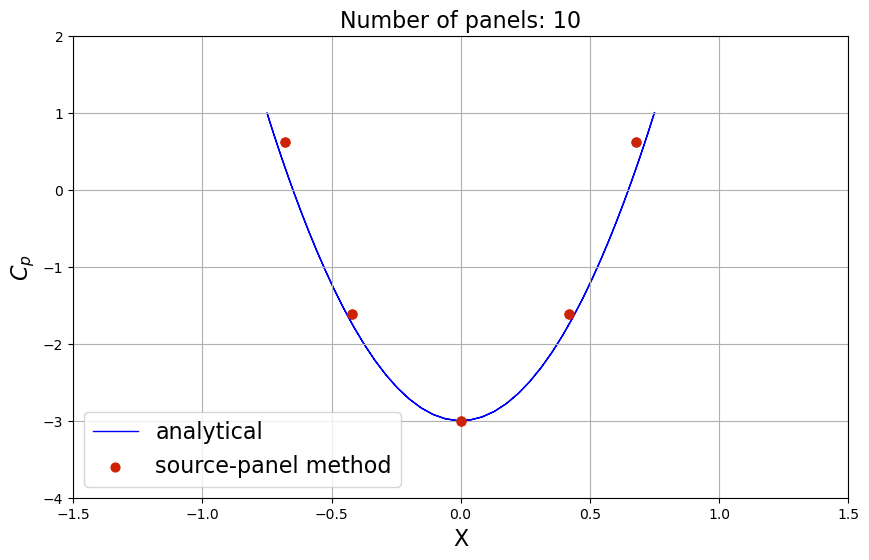

Error for 10 panels: -55.29203070318035
Panel Analysis Complete!


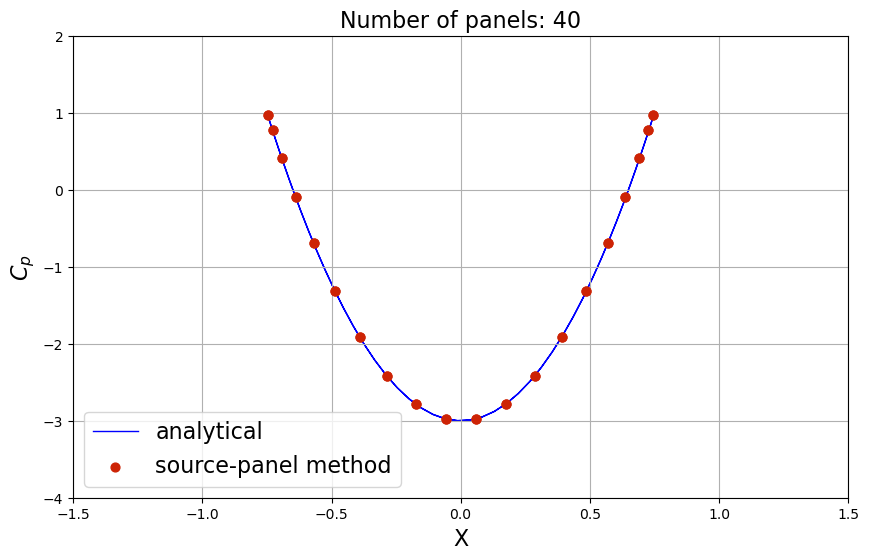

Error for 40 panels: -9.110618695410398
Panel Analysis Complete!


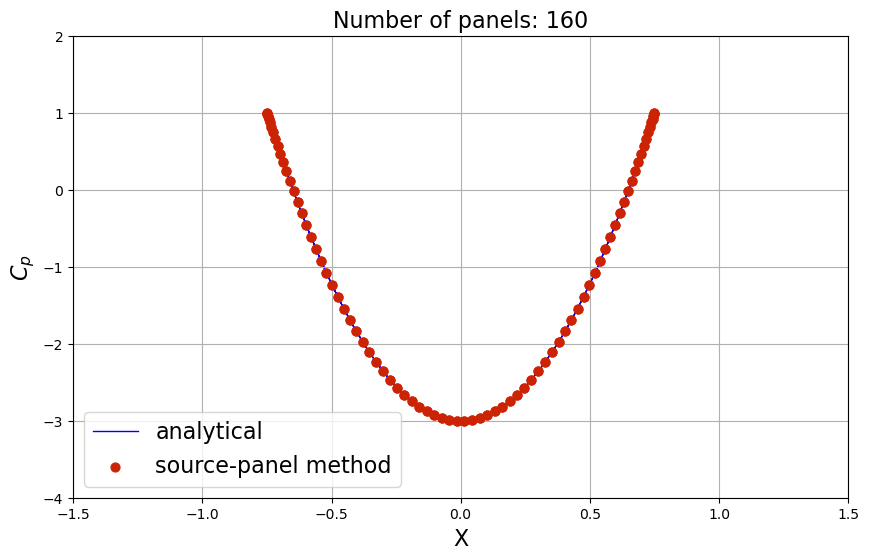

Error for 160 panels: 2.434734306532091


In [14]:
def calculate_error(cylinder_panels, x_circle, cp_analytical, N_panels):
    d_theta = 2 * math.pi / N_panels
    integral_analytical = np.sum(cp_analytical * d_theta)
    integral_panel = np.sum([p.cp * d_theta for p in cylinder_panels])

    error = integral_analytical - integral_panel
    return error

def analyze_and_plot_panels(cylinder_panels, U_infty, x_circle, y_circle, cp_analytical, N_panels):
    analyze_panels(cylinder_panels, U_infty)
    cp_analytical = 1.0 - 4 * (y_circle / R) ** 2

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.xlabel('X', fontsize=16)
    plt.ylabel('$C_p$', fontsize=16)

    plt.plot(x_circle, cp_analytical, label='analytical', color='b', linestyle='-', linewidth=1, zorder=1)

    plt.scatter([p.xc for p in cylinder_panels], [p.cp for p in cylinder_panels], label='source-panel method', color='#CD2305', s=40, zorder=2)

    plt.title('Number of panels: %d' % N_panels, fontsize=16)
    plt.legend(loc='best', prop={'size': 16})
    plt.xlim(-1.5, 1.5)
    plt.ylim(-4.0, 2.0)
    plt.show()

# Call the function for each value in the N_panels array
N_panels = np.array([10, 40, 160])
R = 0.75
U_infty = 1.0
x_circle = R * np.cos(np.linspace(0.0, 2 * math.pi, 100))
y_circle = R * np.sin(np.linspace(0.0, 2 * math.pi, 100))
cp_analytical = 1.0 - 4 * (y_circle / R)**2

for panels in N_panels:
    x_points = R * np.cos(np.linspace(0.0, 2 * math.pi, panels + 1))
    y_points = R * np.sin(np.linspace(0.0, 2 * math.pi, panels + 1))
    
    cylinder_panels = np.empty(panels, dtype=object)
    for i in range(panels):
        cylinder_panels[i] = Panel(x_points[i], y_points[i], x_points[i + 1], y_points[i + 1])

    analyze_and_plot_panels(cylinder_panels, U_infty, x_circle, y_circle, cp_analytical, panels)

    error = calculate_error(cylinder_panels, x_circle, cp_analytical, panels)
    print(f"Error for {panels} panels: {error}")

# Problem 3 Symmetric and Cambered Airfoil Panel Methods

## Approach

The capproach is to  utilizes a panel method approach to discretize the geometry of an airfoil into panels, enabling the calculation of surface pressure coefficients. Additionally, comparing these results with those obtained from XFOIL analysis

## Equations

To find the Viscous flow Reynolds number we utilized the equation

### $Re = \frac{V l}{\mu}$

- At Altitude of 12000 ft

- $V$ = Airspeed ($5\frac{m}{s}$)

- $\mu$ = Kinematic Viscosity ($1.4207*10^{-5} \frac{ft^2}{s}$)

## Code

This code defines a function named define_panels that generates a set of panels based on the provided x and y coordinates, along with an optional parameter N for the number of panels. It calculates the radius of the circle based on the given airfoil geometry, then proceeds to compute the x and y coordinates of the circle. The code extends the arrays, computes the y-coordinate of end-points, and initializes the panels using the calculated coordinates. Finally, it returns the generated panels for further analysis.

In [ ]:
def define_panels(x, y, N= 100):
   
    R = (x.max() - x.min()) / 2                 # Radius of the circle, based on airfoil geometry
    x_center = (x.max() + x.min()) / 2          # X coordinate of center of circle


    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * math.pi, N + 1))
    # Here we define the x coordinates of the circle
    
    x_ends = np.copy(x_circle)                  # projection of the x-coord on the surface
    y_ends = np.empty_like(x_ends)              # initialization of the y-coord Numpy array

    x, y = np.append(x, x[0]), np.append(y, y[0])  # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels



# Symemtric Airfoil NACA 0012 Analysis

## Code

This code first loads airfoil data from a file, then uses a defined function to create panels and plots the airfoil geometry along with the panels. It subsequently performs an analysis using XFOIL, varying the Reynolds number and plotting the pressure coefficient for each case. Finally, it compares the results from XFOIL with those obtained from the source-panel method, showcasing the comparative analysis between the two methods.

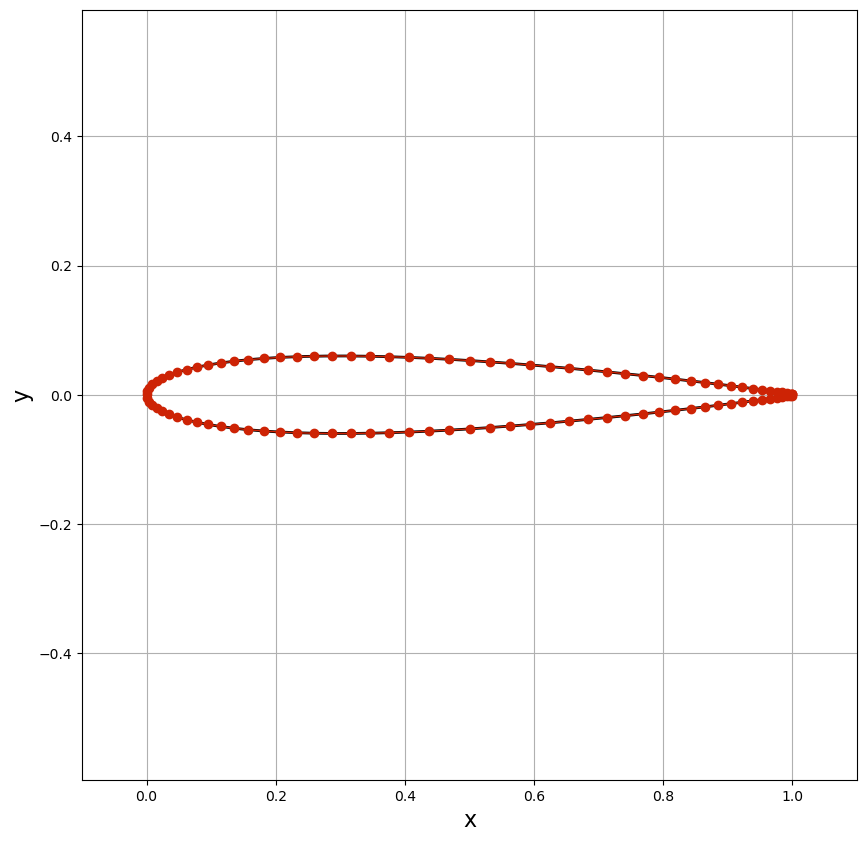

Panel Analysis Complete!
Panel Analysis Complete!


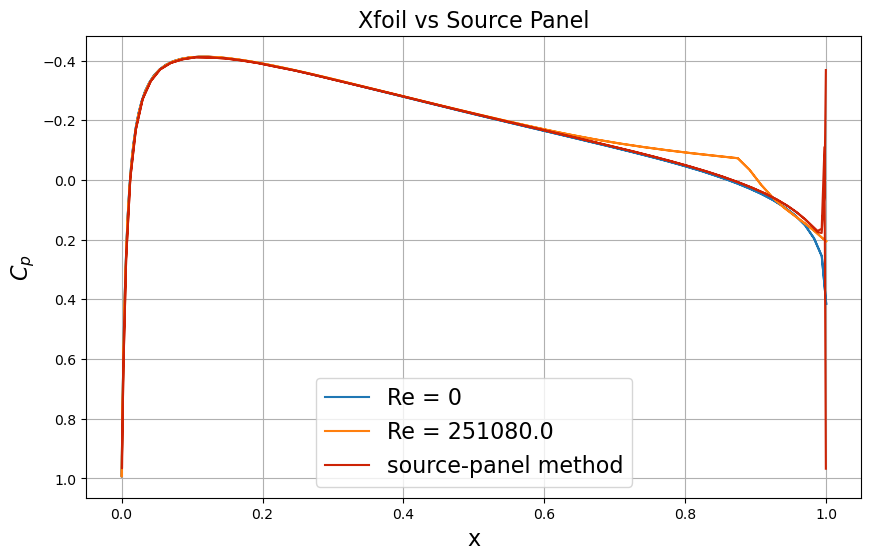

In [ ]:
### NACA 0012 ###
naca = True
alf = 0.0
foil = '0012'
kinvisc = 15.52 * (10**-6)
Re = (10*1)/(kinvisc)
Re = 0
pyxfoil.GetPolar(foil, naca, alf, Re)

filename = 'Data/naca0012/naca0012.dat'
x, y = np.loadtxt(filename, dtype=float, unpack=True, skiprows = 1)

N = 100
panels = define_panels(x,y,N)

# Plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.show()

# Analysis using xfoil
Re_values = [0, 2.5108e+5]  # example Reynolds numbers
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)

for Re in Re_values:
    pyxfoil.GetPolar(foil, naca, alf, Re)
    filename = f'Data/naca0012/naca0012_surfCP_Re{Re:.2e}a{alf}.dat'
    x12, y12, Cp12 = np.loadtxt(filename, unpack=True, skiprows=3)

    U_infty = 5
    analyze_panels(panels, U_infty)

    plt.plot(x12, Cp12, label=f'Re = {Re}')

plt.gca().invert_yaxis()
plt.plot([p.xc for p in panels], [p.cp for p in panels], label='source-panel method', color='#CD2305')
plt.title('Xfoil vs Source Panel', fontsize=16)
plt.legend(loc='best', prop={'size': 16})
plt.show()

# Cambered Airfoil NACA 2414 Analysis

## Code
Same steps were taken as the pervious cell of code. Changed to retrive airfoil data of NACA 2414 instead. 

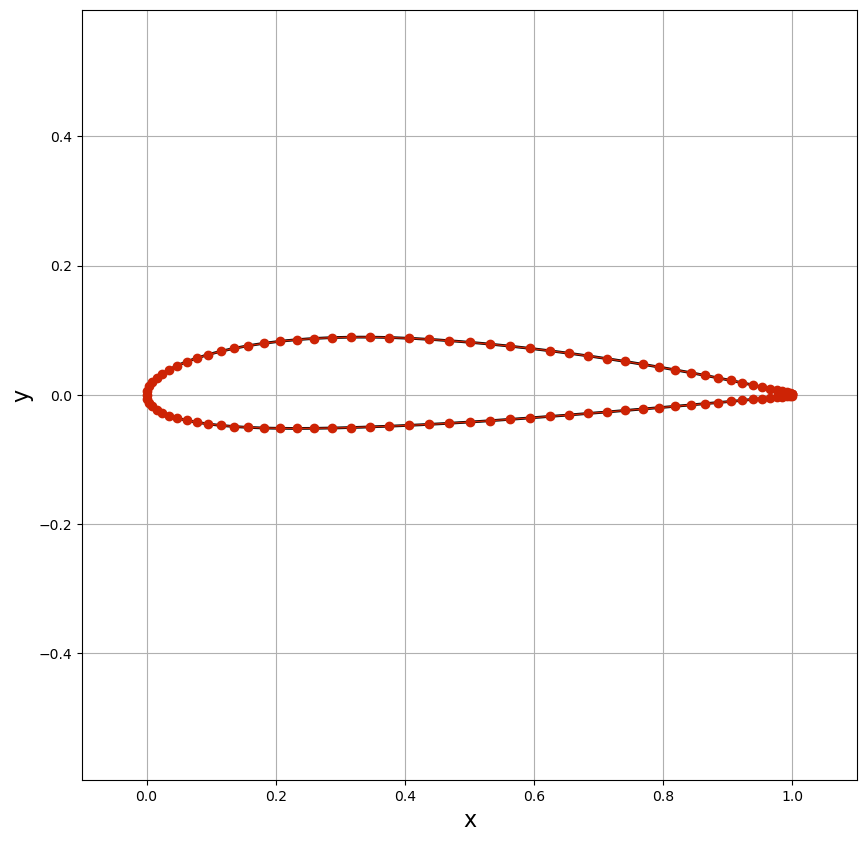

Panel Analysis Complete!
Panel Analysis Complete!


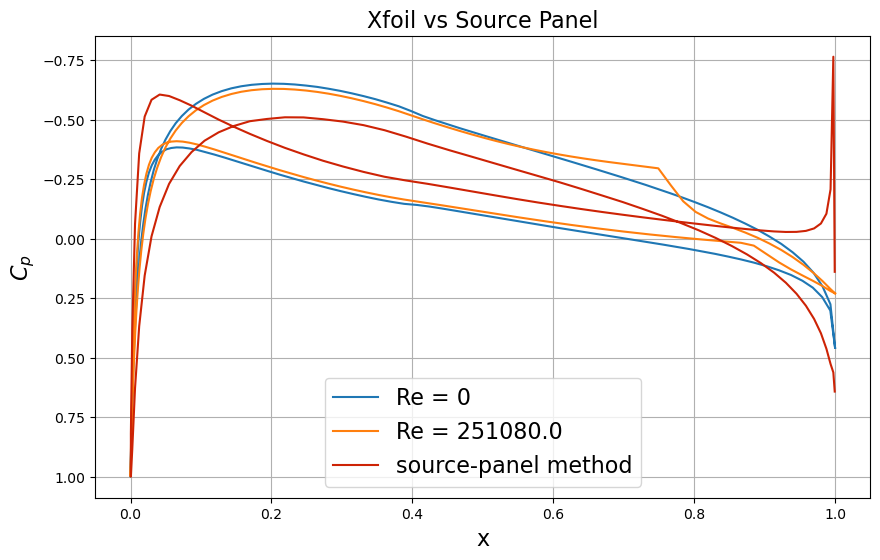

In [ ]:
naca = True
alf = 0.0
foil = '2414'
kinvisc = 15.52 * (10**-6)
Re = (10*1)/(kinvisc)
Re = 0
pyxfoil.GetPolar(foil, naca, alf, Re)

filename = 'Data/naca2414/naca2414.dat'
x, y = np.loadtxt(filename, dtype=float, unpack=True, skiprows = 1)

N = 100
panels = define_panels(x,y,N)

# Plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.show()

# Analysis using xfoil
Re_values = [0, 2.5108e+5]  # example Reynolds numbers
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)

for Re in Re_values:
    pyxfoil.GetPolar(foil, naca, alf, Re)
    filename = f'Data/naca2414/naca2414_surfCP_Re{Re:.2e}a{alf}.dat'
    x12, y12, Cp12 = np.loadtxt(filename, unpack=True, skiprows=3)

    U_infty = 5
    analyze_panels(panels, U_infty)

    plt.plot(x12, Cp12, label=f'Re = {Re}')

plt.gca().invert_yaxis()
plt.plot([p.xc for p in panels], [p.cp for p in panels], label='source-panel method', color='#CD2305')
plt.title('Xfoil vs Source Panel', fontsize=16)
plt.legend(loc='best', prop={'size': 16})
plt.show()

# Analysis 
Comparing the accuracy of the source panel method with XFOIL for a symmetric airfoil, the results generally show good agreement. The pressure coefficient distribution calculated using the source panel method is in close agreement with the values obtained from XFOIL. This agreement confirms the reliability of the source panel method in capturing the aerodynamic characteristics of a symmetric airfoil.

However, when the analysis is repeated with a cambered airfoil, the accuracy of the source panel method tends to diminish. The discrepancies between the source panel method and XFOIL become more noticeable, especially in regions near the airfoil's maximum camber and thickness. This deviation arises due to the inherent assumptions of the source panel method, which assumes a linear distribution of singularities along the airfoil surface. When dealing with cambered airfoils, these assumptions may not accurately capture the complex flow phenomena occurring near the airfoil's surface, leading to discrepancies in the computed pressure coefficients.

The limitations of the source panel method become apparent in its inability to precisely model flow separation, boundary layer effects, and three-dimensional flow features, particularly for cambered airfoils. These limitations restrict the method's accuracy, especially in regions where the flow is separated or turbulent.

To improve the panel method's accuracy, several steps can be taken. Implementing higher-order panels to capture complex flow phenomena near the airfoil surface would enhance the method's accuracy, especially for cambered airfoils. Incorporating corrections for flow separation and boundary layer effects, possibly through empirical corrections or by coupling the panel method with other computational techniques, can further enhance the method's predictive capabilities. Additionally, refining the panel distribution near regions of high curvature or rapid variation in the airfoil geometry can lead to more accurate results. By addressing these limitations, the source panel method can be made more robust and reliable for a broader range of airfoil geometries and flow conditions.

# Problem 4 Additional Problems


# 4.1 Irrotationality

## Equations

### $V = \frac{\Gamma}{2\pi r}$
- V is the velocity vector,
- Γ is the strength of the point source,
- r is the distance from the source.

## Code

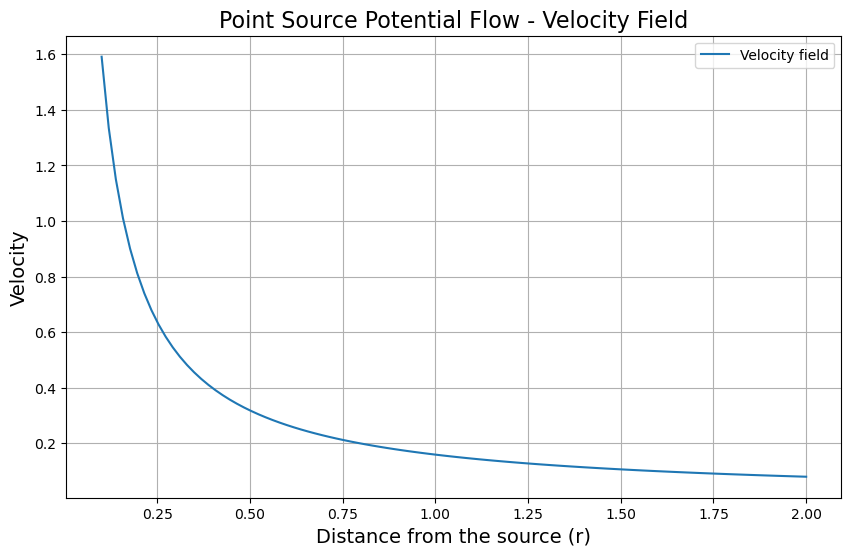

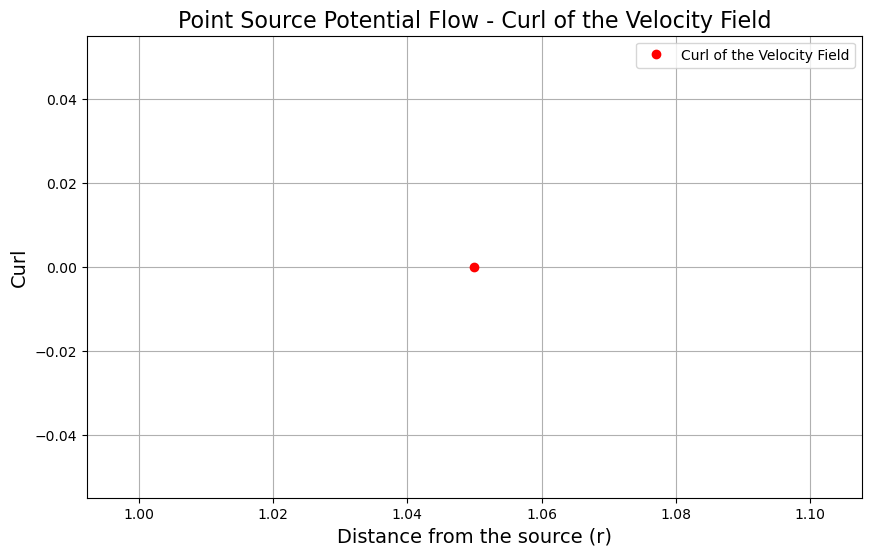

In [ ]:

# Define a function for the velocity field of a point source
def velocity_field(r, gamma):
    return gamma / (2 * np.pi * r)

# Define a function for the curl of the velocity field
def curl_of_velocity_field(r, gamma):
    return 0  # The curl of the velocity field is zero for a point source potential flow

# Create an array of radial distances
r_values = np.linspace(0.1, 2, 100)
gamma = 1  # Example strength of the point source

# Compute the velocity values and curl values
velocity_values = velocity_field(r_values, gamma)
curl_values = curl_of_velocity_field(r_values, gamma)

# Plot the velocity field
plt.figure(figsize=(10, 6))
plt.plot(r_values, velocity_values, label='Velocity field')
plt.xlabel('Distance from the source (r)', fontsize=14)
plt.ylabel('Velocity', fontsize=14)
plt.title('Point Source Potential Flow - Velocity Field', fontsize=16)
plt.legend()
plt.grid()
plt.show()

# Plot the curl of the velocity field
r_values_for_curl = np.mean(r_values)  # Use the mean value of r for the curl calculation
curl_value = curl_of_velocity_field(r_values_for_curl, gamma)

plt.figure(figsize=(10, 6))
plt.plot(r_values_for_curl, curl_value, 'ro', label='Curl of the Velocity Field')
plt.xlabel('Distance from the source (r)', fontsize=14)
plt.ylabel('Curl', fontsize=14)
plt.title('Point Source Potential Flow - Curl of the Velocity Field', fontsize=16)
plt.legend()
plt.grid()
plt.show()



# 4.2 Boundary Layers


Regardless of laminar or turbulent flows the bounrdy layer is rotational because the curl of the velocity gradient is non zero.

## Equations

### $\omega_z = \frac{1}{2} (\frac{\partial U}{\partial x} - \frac{\partial V}{\partial y})$

# 4.3 Potential Flow



## Equations

For a Source Flow

- ### $V = \frac{\Gamma}{2\pi r}$


Free Stream Flow 

- ### $V_{\infty}$

Final Equation

- ### $\sqrt{V_r^2 + V_\infty^2} = \frac{1}{3}V_\infty$


# 4.4 Circular Cylinder

To estimate the pressure on the strut of the 747 carrying the Space Shuttle, we can apply potential flow theory around a cylinder. The pressure distribution on a circular cylinder in a potential flow at an angle of attack can be estimated using the following formula.


### $C_p = 1 - \frac{V}{V_{\infty}}^2$

- $C_p$ Coeffiecent of pressure

### $C_p = \frac{p}{\frac{1}{2} \rho_{\infty} V_{\infty}^2}$

- Airspeed (V) = 175 knots = 90.28 $\frac{m}{s}$
- Air Density ($\rho$) = 0.08891 $\frac{kg}{m^3}$





# Conclusion 
In this problem set, we will implement a source panel method solver to discretize geometry into panels, using functions such as the Panel class, integral_normal(), and integral_tangent(). The goal is to compute the flow over a non-rotating cylinder, analyze symmetric and cambered airfoil panel methods, and solve additional problems related to irrotationality, boundary layers, potential flow, and pressure estimation on a cylindrical strut. Notably, we will be examining the sensitivity of the solution to the number of panels used and comparing the accuracy of the source panel method with XFOIL for different airfoil types. The results and analysis shed light on the behavior of potential flow around various geometries, highlighting the strengths and limitations of the source panel method.